In [1]:
import pandas as pd
pd.options.display.max_columns = 40

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Загрузим данные в df и бегло взглядем на них

In [3]:
tccdf = pd.read_csv('telco-customer-churn.csv')

tccdf.head(10)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,noadditionallines,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,\N,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,3122,624,0,2015,1
5,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,\N,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,2769,553,0,2015,2
6,20,137977,0.05,0.03,4251042488,4,Yes,PhD or equivalent,Male,No,Single,74,\N,1,7,73,Technology Related Job,76,KY,412,159,Yes,No,0.94,834,834,0,2015,1
7,20,137977,0.05,0.03,4251042488,4,Yes,PhD or equivalent,Male,No,Single,74,\N,1,7,73,Technology Related Job,76,KY,412,159,Yes,No,0.94,5868,838,0,2015,2
8,36,136006,0.07,0.00,4251073177,5,Yes,High School or below,Male,Yes,Married,81,\N,0,5,14,Technology Related Job,436,ND,416,19,No,No,0.15,1886,628,0,2015,1
9,36,136006,0.07,0.00,4251073177,5,Yes,High School or below,Male,Yes,Married,81,\N,0,5,14,Technology Related Job,436,ND,416,19,No,No,0.15,2602,867,0,2015,2


In [4]:
print ("rows: " ,tccdf.shape[0])
print ("\ncolumns: " ,tccdf.shape[1])
print ("\nfeatures: \n" ,tccdf.columns.tolist())
print ("\nmissed:  ", tccdf.isnull().sum().values.sum())
print ("\nunique:  \n",tccdf.nunique())
print ("\ndtype:  \n",tccdf.dtypes)

rows:  20468

columns:  29

features: 
 ['age', 'annualincome', 'calldroprate', 'callfailurerate', 'callingnum', 'customerid', 'customersuspended', 'education', 'gender', 'homeowner', 'maritalstatus', 'monthlybilledamount', 'noadditionallines', 'numberofcomplaints', 'numberofmonthunpaid', 'numdayscontractequipmentplanexpiring', 'occupation', 'penaltytoswitch', 'state', 'totalminsusedinlastmonth', 'unpaidbalance', 'usesinternetservice', 'usesvoiceservice', 'percentagecalloutsidenetwork', 'totalcallduration', 'avgcallduration', 'churn', 'year', 'month']

missed:   0

unique:  
 age                                       68
annualincome                            9508
calldroprate                               8
callfailurerate                            4
callingnum                              9525
customerid                              9525
customersuspended                          2
education                                  4
gender                                     2
homeowner   

Имеем *29* колонок, *20468* строк данных, пропусков в данных нет.

Столбец **noadditionallines** состоит из заглушики *\N*, удалим из рассмотрения.

Столбец **year** содержит всего одно значение *2015*, сам год может быть важен как показатель, но в нашем случае никакой информации он не содержит, поэтому его так же можно удалить, оставим только столбец **month**.

In [5]:
tccdf = tccdf.drop(['noadditionallines','year'], axis = 1)

tccdf.head(10)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,5971,663,0,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,3981,995,0,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,7379,737,0,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,1729,432,0,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,3122,624,0,1
5,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,2769,553,0,2
6,20,137977,0.05,0.03,4251042488,4,Yes,PhD or equivalent,Male,No,Single,74,1,7,73,Technology Related Job,76,KY,412,159,Yes,No,0.94,834,834,0,1
7,20,137977,0.05,0.03,4251042488,4,Yes,PhD or equivalent,Male,No,Single,74,1,7,73,Technology Related Job,76,KY,412,159,Yes,No,0.94,5868,838,0,2
8,36,136006,0.07,0.00,4251073177,5,Yes,High School or below,Male,Yes,Married,81,0,5,14,Technology Related Job,436,ND,416,19,No,No,0.15,1886,628,0,1
9,36,136006,0.07,0.00,4251073177,5,Yes,High School or below,Male,Yes,Married,81,0,5,14,Technology Related Job,436,ND,416,19,No,No,0.15,2602,867,0,2


В нашем df осталось 9 категориальных переменных. Пока перекодируем их и сохраним значения в отдельные переменные

In [6]:
customersuspended = {key:n for n,key in enumerate(tccdf.customersuspended.sort_values().unique())}
education = {key:n for n,key in enumerate(tccdf.education.sort_values().unique())}
gender = {key:n for n,key in enumerate(tccdf.gender.sort_values().unique())}
homeowner = {key:n for n,key in enumerate(tccdf.homeowner.sort_values().unique())}
maritalstatus = {key:n for n,key in enumerate(tccdf.maritalstatus.sort_values().unique())}
occupation = {key:n for n,key in enumerate(tccdf.occupation.sort_values().unique())}
state = {key:n for n,key in enumerate(tccdf.state.sort_values().unique())}
usesinternetservice = {key:n for n,key in enumerate(tccdf.usesinternetservice.sort_values().unique())}
usesvoiceservice = {key:n for n,key in enumerate(tccdf.usesvoiceservice.sort_values().unique())}

tccdf = tccdf.replace({'customersuspended': customersuspended,
                     'education': education,
                     'gender': gender,
                     'homeowner': homeowner,
                     'maritalstatus': maritalstatus,
                     'occupation': occupation,
                     'state': state,
                     'usesinternetservice': usesinternetservice,
                     'usesvoiceservice': usesvoiceservice})

print('customersuspended: ', customersuspended)
print('\neducation: ',education)
print('\ngender: ',gender)
print('\nhomeowner: ',homeowner)
print('\nmaritalstatus: ',maritalstatus)
print('\noccupation: ',occupation)
print('\nstate: ',state)
print('\nusesinternetservice: ',usesinternetservice)
print('\nusesvoiceservice: ',usesvoiceservice)

customersuspended:  {'No': 0, 'Yes': 1}

education:  {'Bachelor or equivalent': 0, 'High School or below': 1, 'Master or equivalent': 2, 'PhD or equivalent': 3}

gender:  {'Female': 0, 'Male': 1}

homeowner:  {'No': 0, 'Yes': 1}

maritalstatus:  {'Married': 0, 'Single': 1}

occupation:  {'Non-technology Related Job': 0, 'Others': 1, 'Technology Related Job': 2}

state:  {'AK': 0, 'AL': 1, 'AR': 2, 'AZ': 3, 'CA': 4, 'CO': 5, 'CT': 6, 'DE': 7, 'FL': 8, 'GA': 9, 'HI': 10, 'IA': 11, 'ID': 12, 'IL': 13, 'IN': 14, 'KS': 15, 'KY': 16, 'LA': 17, 'MA': 18, 'MD': 19, 'ME': 20, 'MI': 21, 'MN': 22, 'MO': 23, 'MS': 24, 'MT': 25, 'NC': 26, 'ND': 27, 'NE': 28, 'NH': 29, 'NJ': 30, 'NM': 31, 'NV': 32, 'NY': 33, 'OH': 34, 'OK': 35, 'OR': 36, 'PA': 37, 'RI': 38, 'SC': 39, 'SD': 40, 'TN': 41, 'TX': 42, 'UT': 43, 'VA': 44, 'VT': 45, 'WA': 46, 'WI': 47, 'WV': 48, 'WY': 49}

usesinternetservice:  {'No': 0, 'Yes': 1}

usesvoiceservice:  {'No': 0, 'Yes': 1}


In [7]:
tccdf.head(10)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,month
0,12,168147,0.06,0.00,4251078442,1,1,0,1,1,1,71,0,7,96,2,371,46,15,19,0,0,0.82,5971,663,0,1
1,12,168147,0.06,0.00,4251078442,1,1,0,1,1,1,71,0,7,96,2,371,46,15,19,0,0,0.82,3981,995,0,2
2,42,29047,0.05,0.01,4251043419,2,1,0,0,1,1,8,1,4,14,2,43,47,212,34,0,1,0.27,7379,737,0,1
3,42,29047,0.05,0.01,4251043419,2,1,0,0,1,1,8,1,4,14,2,43,47,212,34,0,1,0.27,1729,432,0,2
4,58,27076,0.07,0.02,4251055773,3,1,2,0,1,1,16,0,2,55,2,403,15,216,144,0,0,0.48,3122,624,0,1
5,58,27076,0.07,0.02,4251055773,3,1,2,0,1,1,16,0,2,55,2,403,15,216,144,0,0,0.48,2769,553,0,2
6,20,137977,0.05,0.03,4251042488,4,1,3,1,0,1,74,1,7,73,2,76,16,412,159,1,0,0.94,834,834,0,1
7,20,137977,0.05,0.03,4251042488,4,1,3,1,0,1,74,1,7,73,2,76,16,412,159,1,0,0.94,5868,838,0,2
8,36,136006,0.07,0.00,4251073177,5,1,1,1,1,0,81,0,5,14,2,436,27,416,19,0,0,0.15,1886,628,0,1
9,36,136006,0.07,0.00,4251073177,5,1,1,1,1,0,81,0,5,14,2,436,27,416,19,0,0,0.15,2602,867,0,2


Столбец **customerid** содержит всего *9525* записей, что свидетельствует о том, что по одному пользователю может быть несколько записей. В зависимости от разметки целевого атрибута **churn**, мы можем иметь дело либо с ретроспективой, когда пользователь, ушедший в любой момент времени будет отмечен как ушедший, либо отметка об оттоке будет соответствовать месяцу ухода клиента, что является более интересным вариантом, поскольку позволило бы оценить изменение активности пользователя перед его уходом. Проверим данную гипотезу, оценив стандартное отклонение целевого показателя по нашим клиентам.

In [8]:
print("mean target std: ", tccdf.groupby(['customerid']).std()['churn'].mean() )

mean target std:  0.0


Отсутствие разброса в сгруппированной целевой переменной свидетельствует о том, что мы не сможем явно выделить момент оттока конкретного клиента, следовательно мы можем лишь попытаться составить примерный портрет интересующих нас людей.

Проверим разброс по всем переменным.

In [9]:
tccdf.groupby(['customerid']).std().mean()

age                                        0.000000
annualincome                               0.000000
calldroprate                               0.000000
callfailurerate                            0.000000
callingnum                                 0.000000
customersuspended                          0.000000
education                                  0.000000
gender                                     0.000000
homeowner                                  0.000000
maritalstatus                              0.000000
monthlybilledamount                        0.000000
numberofcomplaints                         0.000000
numberofmonthunpaid                        0.000000
numdayscontractequipmentplanexpiring       0.000000
occupation                                 0.000000
penaltytoswitch                            0.000000
state                                      0.000000
totalminsusedinlastmonth                   0.000000
unpaidbalance                              0.000000
usesinternet

Как видим, из всех переменных, за вычетом **month**, только **totalcallduration** и **avgcallduration** имеют не нулевую дисперсию. Исходя из названий признаков и их значений, можно предположить, что это, соответственно, общая и средняя длительность звонков в секундах за текщий месяц.

Переменная **callingnum** по своим значениям напоминает телефонный номер, что можно было бы использовать как идентификатор клиента, но им уже присвоены уникальные номера, поэтому данный столбец так же можно удалить из рассмотрения, поскольку каждому пользователю соответствует только один номер.

In [10]:
tccdf = tccdf.drop(['callingnum'], axis = 1)

tccdf.head(10)

,age,annualincome,calldroprate,callfailurerate,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,month
0,12,168147,0.06,0.00,1,1,0,1,1,1,71,0,7,96,2,371,46,15,19,0,0,0.82,5971,663,0,1
1,12,168147,0.06,0.00,1,1,0,1,1,1,71,0,7,96,2,371,46,15,19,0,0,0.82,3981,995,0,2
2,42,29047,0.05,0.01,2,1,0,0,1,1,8,1,4,14,2,43,47,212,34,0,1,0.27,7379,737,0,1
3,42,29047,0.05,0.01,2,1,0,0,1,1,8,1,4,14,2,43,47,212,34,0,1,0.27,1729,432,0,2
4,58,27076,0.07,0.02,3,1,2,0,1,1,16,0,2,55,2,403,15,216,144,0,0,0.48,3122,624,0,1
5,58,27076,0.07,0.02,3,1,2,0,1,1,16,0,2,55,2,403,15,216,144,0,0,0.48,2769,553,0,2
6,20,137977,0.05,0.03,4,1,3,1,0,1,74,1,7,73,2,76,16,412,159,1,0,0.94,834,834,0,1
7,20,137977,0.05,0.03,4,1,3,1,0,1,74,1,7,73,2,76,16,412,159,1,0,0.94,5868,838,0,2
8,36,136006,0.07,0.00,5,1,1,1,1,0,81,0,5,14,2,436,27,416,19,0,0,0.15,1886,628,0,1
9,36,136006,0.07,0.00,5,1,1,1,1,0,81,0,5,14,2,436,27,416,19,0,0,0.15,2602,867,0,2


Соберем новый df, в котором сгруппируем данные по нашим пользователям.

Все признаки, с 0 дисперсией оставим без изменения, а **totalcallduration** и **avgcallduration** разделим на колонки по месяцам.

In [11]:
tccdf_pt = tccdf.groupby(['customerid'], as_index = False).mean()

tccdf_pt.head(10)

,customerid,age,annualincome,calldroprate,callfailurerate,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,month
0,1,12.0,168147.0,0.06,0.00,1.0,0.0,1.0,1.0,1.0,71.0,0.0,7.0,96.0,2.0,371.0,46.0,15.0,19.0,0.0,0.0,0.82,4976.000000,829.000000,0.0,1.5
1,2,42.0,29047.0,0.05,0.01,1.0,0.0,0.0,1.0,1.0,8.0,1.0,4.0,14.0,2.0,43.0,47.0,212.0,34.0,0.0,1.0,0.27,4554.000000,584.500000,0.0,1.5
2,3,58.0,27076.0,0.07,0.02,1.0,2.0,0.0,1.0,1.0,16.0,0.0,2.0,55.0,2.0,403.0,15.0,216.0,144.0,0.0,0.0,0.48,2945.500000,588.500000,0.0,1.5
3,4,20.0,137977.0,0.05,0.03,1.0,3.0,1.0,0.0,1.0,74.0,1.0,7.0,73.0,2.0,76.0,16.0,412.0,159.0,1.0,0.0,0.94,3351.000000,836.000000,0.0,1.5
4,5,36.0,136006.0,0.07,0.00,1.0,1.0,1.0,1.0,0.0,81.0,0.0,5.0,14.0,2.0,436.0,27.0,416.0,19.0,0.0,0.0,0.15,2244.000000,747.500000,0.0,1.5
5,6,67.0,246906.0,0.05,0.01,1.0,1.0,0.0,1.0,0.0,19.0,1.0,2.0,32.0,2.0,108.0,35.0,113.0,34.0,0.0,0.0,0.61,4291.000000,613.000000,0.0,1.5
6,7,14.0,244935.0,0.07,0.02,1.0,1.0,1.0,1.0,1.0,27.0,3.0,0.0,73.0,2.0,468.0,3.0,116.0,144.0,0.0,0.0,0.82,2885.000000,683.000000,0.0,1.5
7,8,45.0,105835.0,0.05,0.03,1.0,1.0,0.0,1.0,0.0,85.0,1.0,5.0,91.0,2.0,141.0,4.0,313.0,159.0,0.0,0.0,0.27,3664.000000,814.000000,0.0,1.5
8,9,61.0,103864.0,0.07,0.00,1.0,0.0,0.0,1.0,1.0,92.0,3.0,3.0,32.0,2.0,1.0,21.0,316.0,19.0,0.0,0.0,0.48,1711.666667,448.000000,0.0,2.0
9,10,23.0,214765.0,0.06,0.01,1.0,0.0,1.0,1.0,1.0,30.0,0.0,0.0,50.0,2.0,173.0,22.0,13.0,34.0,0.0,0.0,0.94,2241.333333,665.333333,1.0,2.0


Соберем себе сводную табличку со звонками пользователей по месяцам.

In [12]:
pt = tccdf[['customerid', 'month', 'totalcallduration', 'avgcallduration']]

pt = pd.pivot_table(pt, values=['totalcallduration', 'avgcallduration'],
                     index=['customerid'], columns=['month'])

index_pt = pt.columns.get_level_values(0).values + '_'+ \
            pt.columns.get_level_values(1).values.astype(str)
    
pt.columns = index_pt

pt = pt.reset_index()

pt.head(10)

,customerid,avgcallduration_1,avgcallduration_2,avgcallduration_3,totalcallduration_1,totalcallduration_2,totalcallduration_3
0,1,663.0,995.0,NaN,5971.0,3981.0,NaN
1,2,737.0,432.0,NaN,7379.0,1729.0,NaN
2,3,624.0,553.0,NaN,3122.0,2769.0,NaN
3,4,834.0,838.0,NaN,834.0,5868.0,NaN
4,5,628.0,867.0,NaN,1886.0,2602.0,NaN
5,6,391.0,835.0,NaN,2737.0,5845.0,NaN
6,7,557.0,809.0,NaN,3342.0,2428.0,NaN
7,8,815.0,813.0,NaN,2446.0,4882.0,NaN
8,9,516.0,560.0,268.0,2065.0,2802.0,268.0
9,10,755.0,615.0,626.0,3022.0,3076.0,626.0


Добавим несколько новых переменных, а именно отношение длительности звонков в 3 месяце к 1 и 2, отношение звонков во 2 месяце к 1, максимальное, минимальное, среднее значение и сумму по длительности звонков.

In [13]:
pt['avgcallduration_3/2'] = np.where(pt['avgcallduration_2'] == 0, 0,\
                                     pt['avgcallduration_3'] / pt['avgcallduration_2'])
pt['avgcallduration_3/1'] = np.where(pt['avgcallduration_1'] == 0, 0,\
                                     pt['avgcallduration_3'] / pt['avgcallduration_1'])
pt['avgcallduration_2/1'] = np.where(pt['avgcallduration_1'] == 0, 0, \
                                     pt['avgcallduration_2'] / pt['avgcallduration_1'])

pt['avgcallduration_max'] = pt[['avgcallduration_1', 'avgcallduration_2', 'avgcallduration_3']].max(axis = 1)
pt['avgcallduration_min'] = pt[['avgcallduration_1', 'avgcallduration_2', 'avgcallduration_3']].min(axis = 1)
pt['avgcallduration_mean'] = pt[['avgcallduration_1', 'avgcallduration_2', 'avgcallduration_3']].mean(axis = 1)
pt['avgcallduration_sum'] = pt[['avgcallduration_1', 'avgcallduration_2', 'avgcallduration_3']].sum(axis = 1)

pt['totalcallduration_3/2'] = np.where(pt['totalcallduration_2'] == 0, 0,\
                                     pt['totalcallduration_3'] / pt['totalcallduration_2'])
pt['totalcallduration_3/1'] = np.where(pt['totalcallduration_1'] == 0, 0,\
                                     pt['totalcallduration_3'] / pt['totalcallduration_1'])
pt['totalcallduration_2/1'] = np.where(pt['totalcallduration_1'] == 0, 0,\
                                     pt['totalcallduration_2'] / pt['totalcallduration_1'])

pt['totalcallduration_max'] = pt[['totalcallduration_1', 'totalcallduration_2', 'totalcallduration_3']].max(axis = 1)
pt['totalcallduration_min'] = pt[['totalcallduration_1', 'totalcallduration_2', 'totalcallduration_3']].min(axis = 1)
pt['totalcallduration_mean'] = pt[['totalcallduration_1', 'totalcallduration_2', 'totalcallduration_3']].mean(axis = 1)
pt['totalcallduration_sum'] = pt[['totalcallduration_1', 'totalcallduration_2', 'totalcallduration_3']].sum(axis = 1)

Заменим пропуски в данных на 0.

In [14]:
pt = pt.fillna(0)

pt.head(10)

,customerid,avgcallduration_1,avgcallduration_2,avgcallduration_3,totalcallduration_1,totalcallduration_2,totalcallduration_3,avgcallduration_3/2,avgcallduration_3/1,avgcallduration_2/1,avgcallduration_max,avgcallduration_min,avgcallduration_mean,avgcallduration_sum,totalcallduration_3/2,totalcallduration_3/1,totalcallduration_2/1,totalcallduration_max,totalcallduration_min,totalcallduration_mean,totalcallduration_sum
0,1,663.0,995.0,0.0,5971.0,3981.0,0.0,0.000000,0.000000,1.500754,995.0,663.0,829.000000,1658.0,0.000000,0.000000,0.666722,5971.0,3981.0,4976.000000,9952.0
1,2,737.0,432.0,0.0,7379.0,1729.0,0.0,0.000000,0.000000,0.586160,737.0,432.0,584.500000,1169.0,0.000000,0.000000,0.234314,7379.0,1729.0,4554.000000,9108.0
2,3,624.0,553.0,0.0,3122.0,2769.0,0.0,0.000000,0.000000,0.886218,624.0,553.0,588.500000,1177.0,0.000000,0.000000,0.886931,3122.0,2769.0,2945.500000,5891.0
3,4,834.0,838.0,0.0,834.0,5868.0,0.0,0.000000,0.000000,1.004796,838.0,834.0,836.000000,1672.0,0.000000,0.000000,7.035971,5868.0,834.0,3351.000000,6702.0
4,5,628.0,867.0,0.0,1886.0,2602.0,0.0,0.000000,0.000000,1.380573,867.0,628.0,747.500000,1495.0,0.000000,0.000000,1.379639,2602.0,1886.0,2244.000000,4488.0
5,6,391.0,835.0,0.0,2737.0,5845.0,0.0,0.000000,0.000000,2.135550,835.0,391.0,613.000000,1226.0,0.000000,0.000000,2.135550,5845.0,2737.0,4291.000000,8582.0
6,7,557.0,809.0,0.0,3342.0,2428.0,0.0,0.000000,0.000000,1.452424,809.0,557.0,683.000000,1366.0,0.000000,0.000000,0.726511,3342.0,2428.0,2885.000000,5770.0
7,8,815.0,813.0,0.0,2446.0,4882.0,0.0,0.000000,0.000000,0.997546,815.0,813.0,814.000000,1628.0,0.000000,0.000000,1.995912,4882.0,2446.0,3664.000000,7328.0
8,9,516.0,560.0,268.0,2065.0,2802.0,268.0,0.478571,0.519380,1.085271,560.0,268.0,448.000000,1344.0,0.095646,0.129782,1.356901,2802.0,268.0,1711.666667,5135.0
9,10,755.0,615.0,626.0,3022.0,3076.0,626.0,1.017886,0.829139,0.814570,755.0,615.0,665.333333,1996.0,0.203511,0.207148,1.017869,3076.0,626.0,2241.333333,6724.0


Добавим полученные переменные к нашей матрице и исключим из нее исходные признаки о длительности звонков и номер месяца.

In [15]:
tccdf_pt = tccdf_pt.merge(pt, how='left', on='customerid')
tccdf_pt = tccdf_pt.drop(['month', 'totalcallduration', 'avgcallduration'], axis = 1)
tccdf_pt.head(10)

,customerid,age,annualincome,calldroprate,callfailurerate,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,...,avgcallduration_1,avgcallduration_2,avgcallduration_3,totalcallduration_1,totalcallduration_2,totalcallduration_3,avgcallduration_3/2,avgcallduration_3/1,avgcallduration_2/1,avgcallduration_max,avgcallduration_min,avgcallduration_mean,avgcallduration_sum,totalcallduration_3/2,totalcallduration_3/1,totalcallduration_2/1,totalcallduration_max,totalcallduration_min,totalcallduration_mean,totalcallduration_sum
0,1,12.0,168147.0,0.06,0.00,1.0,0.0,1.0,1.0,1.0,71.0,0.0,7.0,96.0,2.0,371.0,46.0,15.0,19.0,0.0,...,663.0,995.0,0.0,5971.0,3981.0,0.0,0.000000,0.000000,1.500754,995.0,663.0,829.000000,1658.0,0.000000,0.000000,0.666722,5971.0,3981.0,4976.000000,9952.0
1,2,42.0,29047.0,0.05,0.01,1.0,0.0,0.0,1.0,1.0,8.0,1.0,4.0,14.0,2.0,43.0,47.0,212.0,34.0,0.0,...,737.0,432.0,0.0,7379.0,1729.0,0.0,0.000000,0.000000,0.586160,737.0,432.0,584.500000,1169.0,0.000000,0.000000,0.234314,7379.0,1729.0,4554.000000,9108.0
2,3,58.0,27076.0,0.07,0.02,1.0,2.0,0.0,1.0,1.0,16.0,0.0,2.0,55.0,2.0,403.0,15.0,216.0,144.0,0.0,...,624.0,553.0,0.0,3122.0,2769.0,0.0,0.000000,0.000000,0.886218,624.0,553.0,588.500000,1177.0,0.000000,0.000000,0.886931,3122.0,2769.0,2945.500000,5891.0
3,4,20.0,137977.0,0.05,0.03,1.0,3.0,1.0,0.0,1.0,74.0,1.0,7.0,73.0,2.0,76.0,16.0,412.0,159.0,1.0,...,834.0,838.0,0.0,834.0,5868.0,0.0,0.000000,0.000000,1.004796,838.0,834.0,836.000000,1672.0,0.000000,0.000000,7.035971,5868.0,834.0,3351.000000,6702.0
4,5,36.0,136006.0,0.07,0.00,1.0,1.0,1.0,1.0,0.0,81.0,0.0,5.0,14.0,2.0,436.0,27.0,416.0,19.0,0.0,...,628.0,867.0,0.0,1886.0,2602.0,0.0,0.000000,0.000000,1.380573,867.0,628.0,747.500000,1495.0,0.000000,0.000000,1.379639,2602.0,1886.0,2244.000000,4488.0
5,6,67.0,246906.0,0.05,0.01,1.0,1.0,0.0,1.0,0.0,19.0,1.0,2.0,32.0,2.0,108.0,35.0,113.0,34.0,0.0,...,391.0,835.0,0.0,2737.0,5845.0,0.0,0.000000,0.000000,2.135550,835.0,391.0,613.000000,1226.0,0.000000,0.000000,2.135550,5845.0,2737.0,4291.000000,8582.0
6,7,14.0,244935.0,0.07,0.02,1.0,1.0,1.0,1.0,1.0,27.0,3.0,0.0,73.0,2.0,468.0,3.0,116.0,144.0,0.0,...,557.0,809.0,0.0,3342.0,2428.0,0.0,0.000000,0.000000,1.452424,809.0,557.0,683.000000,1366.0,0.000000,0.000000,0.726511,3342.0,2428.0,2885.000000,5770.0
7,8,45.0,105835.0,0.05,0.03,1.0,1.0,0.0,1.0,0.0,85.0,1.0,5.0,91.0,2.0,141.0,4.0,313.0,159.0,0.0,...,815.0,813.0,0.0,2446.0,4882.0,0.0,0.000000,0.000000,0.997546,815.0,813.0,814.000000,1628.0,0.000000,0.000000,1.995912,4882.0,2446.0,3664.000000,7328.0
8,9,61.0,103864.0,0.07,0.00,1.0,0.0,0.0,1.0,1.0,92.0,3.0,3.0,32.0,2.0,1.0,21.0,316.0,19.0,0.0,...,516.0,560.0,268.0,2065.0,2802.0,268.0,0.478571,0.519380,1.085271,560.0,268.0,448.000000,1344.0,0.095646,0.129782,1.356901,2802.0,268.0,1711.666667,5135.0
9,10,23.0,214765.0,0.06,0.01,1.0,0.0,1.0,1.0,1.0,30.0,0.0,0.0,50.0,2.0,173.0,22.0,13.0,34.0,0.0,...,755.0,615.0,626.0,3022.0,3076.0,626.0,1.017886,0.829139,0.814570,755.0,615.0,665.333333,1996.0,0.203511,0.207148,1.017869,3076.0,626.0,2241.333333,6724.0


Переменные **education**, **occupation** и **state** содержат больше 2 возможных классов, поэтому, для упрощения работы алгоритмов, заменим их на фиктивные переменные.

In [16]:
tccdf_pt = pd.concat([tccdf_pt, pd.get_dummies(tccdf_pt.education, prefix = 'education')], axis=1)
tccdf_pt = pd.concat([tccdf_pt, pd.get_dummies(tccdf_pt.occupation, prefix = 'occupation')], axis=1)
tccdf_pt = pd.concat([tccdf_pt, pd.get_dummies(tccdf_pt.state, prefix = 'state')], axis=1)

tccdf_pt = tccdf_pt.drop(['education', 'occupation', 'state'], axis = 1)

tccdf_pt.head(10)

,customerid,age,annualincome,calldroprate,callfailurerate,customersuspended,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,penaltytoswitch,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,churn,...,state_30.0,state_31.0,state_32.0,state_33.0,state_34.0,state_35.0,state_36.0,state_37.0,state_38.0,state_39.0,state_40.0,state_41.0,state_42.0,state_43.0,state_44.0,state_45.0,state_46.0,state_47.0,state_48.0,state_49.0
0,1,12.0,168147.0,0.06,0.00,1.0,1.0,1.0,1.0,71.0,0.0,7.0,96.0,371.0,15.0,19.0,0.0,0.0,0.82,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2,42.0,29047.0,0.05,0.01,1.0,0.0,1.0,1.0,8.0,1.0,4.0,14.0,43.0,212.0,34.0,0.0,1.0,0.27,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,58.0,27076.0,0.07,0.02,1.0,0.0,1.0,1.0,16.0,0.0,2.0,55.0,403.0,216.0,144.0,0.0,0.0,0.48,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,20.0,137977.0,0.05,0.03,1.0,1.0,0.0,1.0,74.0,1.0,7.0,73.0,76.0,412.0,159.0,1.0,0.0,0.94,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,36.0,136006.0,0.07,0.00,1.0,1.0,1.0,0.0,81.0,0.0,5.0,14.0,436.0,416.0,19.0,0.0,0.0,0.15,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,67.0,246906.0,0.05,0.01,1.0,0.0,1.0,0.0,19.0,1.0,2.0,32.0,108.0,113.0,34.0,0.0,0.0,0.61,0.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,14.0,244935.0,0.07,0.02,1.0,1.0,1.0,1.0,27.0,3.0,0.0,73.0,468.0,116.0,144.0,0.0,0.0,0.82,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,8,45.0,105835.0,0.05,0.03,1.0,0.0,1.0,0.0,85.0,1.0,5.0,91.0,141.0,313.0,159.0,0.0,0.0,0.27,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,61.0,103864.0,0.07,0.00,1.0,0.0,1.0,1.0,92.0,3.0,3.0,32.0,1.0,316.0,19.0,0.0,0.0,0.48,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,10,23.0,214765.0,0.06,0.01,1.0,1.0,1.0,1.0,30.0,0.0,0.0,50.0,173.0,13.0,34.0,0.0,0.0,0.94,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Посмотрим на нашу целевую переменную.

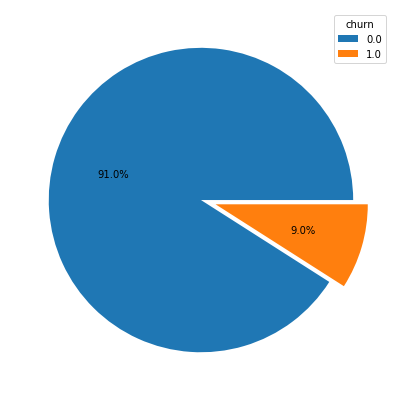

In [17]:
labels = tccdf_pt.churn.value_counts().keys().tolist()
values = tccdf_pt.churn.value_counts().values.tolist()
explode = (0, 0.1)  

fig, ax = plt.subplots(figsize=(7, 7))

ax.pie(values, explode=explode, autopct='%1.1f%%')

ax.legend(labels,
          title="churn",
          loc="best")

plt.show()

Отток клиентов, по представленным данным, составляет 9% от их общего числа.

Начнем с простого, посмотрим на корреляции между нашими признаками и целевой переменной. 

In [18]:
tccdf_pt.corr()

,customerid,age,annualincome,calldroprate,callfailurerate,customersuspended,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,penaltytoswitch,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,churn,...,state_30.0,state_31.0,state_32.0,state_33.0,state_34.0,state_35.0,state_36.0,state_37.0,state_38.0,state_39.0,state_40.0,state_41.0,state_42.0,state_43.0,state_44.0,state_45.0,state_46.0,state_47.0,state_48.0,state_49.0
customerid,1.000000,-0.005557,-0.002851,-0.003656,0.004010,-0.007480,-0.000654,-0.005577,-0.002289,-0.000997,-0.000804,-0.000629,-0.001680,0.001081,0.001172,-0.053382,-0.004148,0.001743,-0.011776,0.001638,...,0.006480,0.003587,-0.001040,-0.004982,-0.019845,0.011271,-0.004034,-0.007416,0.027169,-0.019478,-0.010892,0.014748,-0.003502,-0.010333,-0.017218,0.026285,-0.013636,-0.010327,0.022684,0.003903
age,-0.005557,1.000000,-0.007234,-0.011838,0.002302,0.004519,0.042774,0.003148,-0.012839,-0.003186,0.006678,-0.002866,0.011849,0.006091,0.008345,-0.005452,0.002492,0.018391,-0.005203,-0.134273,...,-0.007315,-0.005716,-0.003605,-0.014983,-0.006741,-0.003786,0.001868,-0.006653,-0.006046,0.008217,0.000669,0.002843,-0.005215,-0.004766,-0.001611,0.006687,0.001810,0.006243,0.009224,-0.000729
annualincome,-0.002851,-0.007234,1.000000,-0.004807,0.002535,-0.007982,-0.002239,0.010049,-0.003477,-0.008848,0.000324,-0.000873,0.005567,0.008582,0.000913,0.006961,0.007053,-0.002751,-0.004796,-0.003224,...,-0.015459,-0.001063,-0.003239,-0.006303,0.009243,0.009576,0.006483,-0.000740,0.004729,-0.005800,-0.000177,-0.013698,-0.008655,-0.001671,0.006242,0.000470,0.000716,-0.000921,0.012276,0.001484
calldroprate,-0.003656,-0.011838,-0.004807,1.000000,-0.011346,0.008957,0.088742,0.001837,-0.001918,-0.004735,0.027423,0.008865,0.003951,-0.003924,0.022881,-0.004945,0.006016,0.015734,0.007076,0.007033,...,0.015427,-0.004496,-0.008495,-0.000794,0.009195,0.000176,0.001171,0.005160,0.004428,-0.008552,-0.003505,0.021116,0.015665,-0.005899,-0.009631,0.003612,-0.006447,-0.001111,-0.013406,-0.007388
callfailurerate,0.004010,0.002302,0.002535,-0.011346,1.000000,0.012052,0.004298,-0.001480,-0.000287,-0.004589,0.001783,-0.001214,-0.001833,0.002739,0.001218,-0.044214,0.002414,-0.007938,-0.001164,0.005795,...,0.001364,-0.006274,-0.019951,0.017857,0.034451,0.015152,-0.009010,-0.022993,-0.016393,-0.026176,-0.028082,-0.019895,0.004137,0.002228,0.022526,0.015506,0.027208,0.001428,0.015161,-0.015270
customersuspended,-0.007480,0.004519,-0.007982,0.008957,0.012052,1.000000,0.002106,-0.002127,-0.022881,-0.001160,-0.011988,0.005993,-0.005471,0.001266,-0.004352,-0.012023,0.018740,-0.000625,0.008264,-0.008505,...,-0.001038,-0.005608,-0.010880,0.012647,-0.003279,0.009858,-0.016152,-0.002703,-0.006531,0.000230,0.016808,0.003255,-0.018191,-0.013463,0.000564,0.003902,-0.007665,-0.002477,0.014286,0.007220
gender,-0.000654,0.042774,-0.002239,0.088742,0.004298,0.002106,1.000000,-0.010235,-0.005892,-0.000625,0.010514,0.011986,0.009944,-0.003511,0.010699,-0.002341,0.004426,-0.003508,0.015045,-0.007969,...,0.003386,-0.004227,-0.005761,-0.000548,0.014584,-0.004349,-0.001158,0.002225,-0.000534,-0.000292,-0.002953,-0.007949,-0.005114,0.003614,0.003521,-0.002963,0.002225,-0.007809,0.009707,0.002225
homeowner,-0.005577,0.003148,0.010049,0.001837,-0.001480,-0.002127,-0.010235,1.000000,-0.003734,0.001594,-0.001902,-0.000813,-0.010928,0.000424,0.001953,0.002017,0.000219,0.006671,-0.006386,-0.006308,...,0.008151,0.000730,-0.014610,0.013129,-0.003326,0.003065,-0.005022,0.012955,-0.001991,0.010181,-0.012459,0.012403,-0.004776,0.005455,-0.000037,-0.009104,-0.017725,-0.006146,0.000366,0.011150
maritalstatus,-0.002289,-0.012839,-0.003477,-0.001918,-0.000287,-0.022881,-0.005892,-0.003734,1.000000,0.003319,-0.006563,-0.018596,0.007340,-0.004642,-0.001559,-0.002523,0.008276,-0.009898,-0.005379,0.021611,...,0.006490,0.009356,-0.012121,-0.004577,-0.000876,0.017278,-0.

In [19]:
tccdf_pt.corr().churn.sort_values()

age                                    -0.134273
state_45.0                             -0.026252
education_2.0                          -0.024700
avgcallduration_1                      -0.023437
totalcallduration_1                    -0.019922
state_28.0                             -0.018977
state_1.0                              -0.017805
numdayscontractequipmentplanexpiring   -0.016322
state_30.0                             -0.016066
state_17.0                             -0.015580
percentagecalloutsidenetwork           -0.014797
state_19.0                             -0.013203
occupation_2.0                         -0.011336
totalcallduration_mean                 -0.011134
state_22.0                             -0.010133
totalcallduration_max                  -0.010093
totalcallduration_sum                  -0.009779
customersuspended                      -0.008505
state_41.0                             -0.008409
gender                                 -0.007969
state_14.0          

Как видим, никаких выдающихся значений коэффициентов корреляции не обнаруживается. 

Разделим наши данные на целевую переменную и показатели для прогноза.

In [20]:
Y = tccdf_pt.churn

X = tccdf_pt.drop(['customerid', 'churn'], axis = 1)

Выделим 10% данных для валидации нашей будущей модели.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, 
                                                    random_state=42)

В качестве самой простой модели, попробуем использовать **LogisticRegression**.

In [44]:
lr = LogisticRegression(random_state=42)

In [45]:
lr.fit(X_train.values, y_train.values)

/home/ccord/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Получим наши прогнозные значения на тренировочных и тестовых данных

In [46]:
y_train_pred_lr = lr.predict(X_train.values)
y_test_pred_lr = lr.predict(X_test.values)

Посчитаем точность нашего прогноза на обучающей и валидационной выборке по метрике **accuracy**

In [47]:
print('accuracy train: ', accuracy_score(y_train, y_train_pred_lr))
print('\naccuracy test: ', accuracy_score(y_test, y_test_pred_lr))

accuracy train:  0.908306112925805

accuracy test:  0.9213011542497377


Само значение точности в вакууме ничего не скажет нам о том, сможем ли мы использовать модель в будущем. Построим матрицу ошибок для наших выборок, чтобы оценить предиктивные способности модели.

В зависимости от конкретной цели нам может быть интересна либо **precision** либо **recall** нашей модели. Определить это следует из того, для каких целей мы планируем использовать нашу модель. Найти всех пользователей, которые планируют уйти и предложить им более выгодные условия? Тогда придется балансировать между возможностью не найти всех нужных клиентов (упущенная прибыль от их ухода) и тем, что мы слишком часто будем считать обычных клиентов как потенциальный отток (затраты на предоставление более выгодных условий). И это только часть задач, которые следует определить для себя до того, как приступить к выбору модели.

Пока попробуем просто взглянуть на нашу модель со всех оценок.

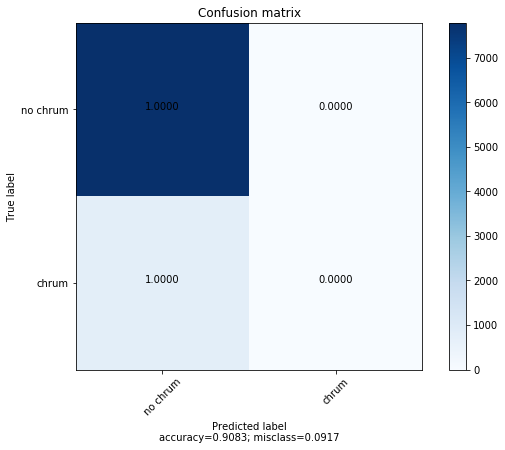

In [48]:
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred_lr),
                      target_names=['no chrum', 'chrum'])

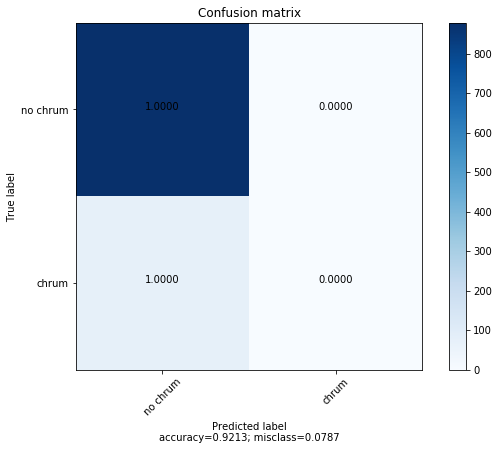

In [27]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred_lr),
                      target_names=['no chrum', 'chrum'])

Как видим, наша модель решила упростить себе жизнь и записать все наблюдения в преобладающий класс.

Для построения модели, которую, при желании, можно попытаться интерпретировать, воспользуемся **RandomForestClassifier** из пакета **sklearn.ensemble**.

In [28]:
rfc = RandomForestClassifier(n_estimators=13,
                             random_state=42)

In [29]:
rfc.fit(X_train.values, y_train.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Получим наши прогнозные значения на тренировочных и тестовых данных

In [30]:
y_train_pred_rfc = rfc.predict(X_train.values)
y_test_pred_rfc = rfc.predict(X_test.values)

Посчитаем точность нашего прогноза на обучающей и валидационной выборке по метрике **accuracy**

In [31]:
print('accuracy train: ', accuracy_score(y_train, y_train_pred_rfc))
print('\naccuracy test: ', accuracy_score(y_test, y_test_pred_rfc))

accuracy train:  0.9917172188520765

accuracy test:  0.919202518363064


Построим матрицу ошибок для наших выборок, чтобы оценить предиктивные способности модели.

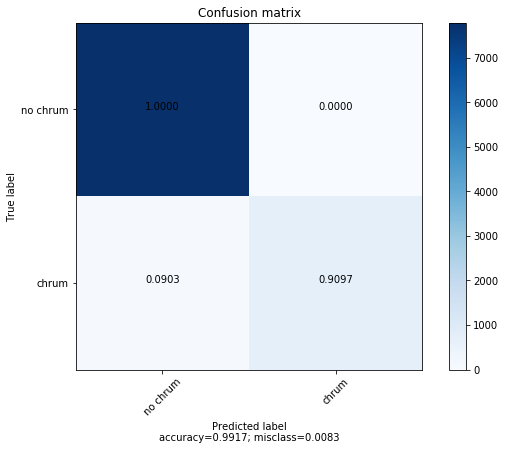

In [32]:
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred_rfc),
                      target_names=['no chrum', 'chrum'])

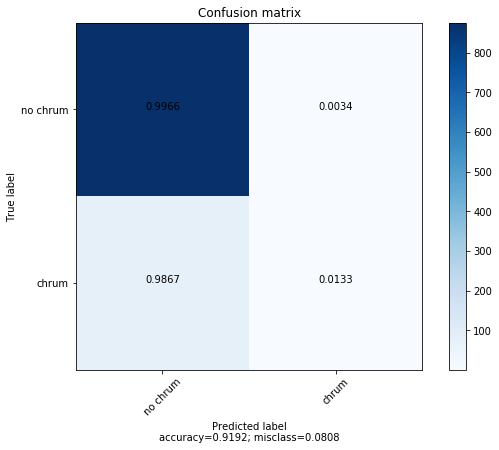

In [33]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred_rfc),
                      target_names=['no chrum', 'chrum'])

Вторая модель повела себя намного лучше, и на обучающей выборке нашла 90% ушедших клиентов.

Валидация же показала результат, сопоставимый с полученным линейной регрессией, что явно не подходит для наших целей. Таким образом, делаем вывод, что модель переобучилась на предложенный тренировочный датасет и и ее использование в реальной работе грозит тем, что мы практически не найдем клиентов, которые собираются уходить.

Попробуем еще несколько моделей.

Начнем с **GradientBoostingClassifier**

In [34]:
gbc = GradientBoostingClassifier(learning_rate=0.01,
                             random_state=42)

In [35]:
gbc.fit(X_train.values, y_train.values)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Получим наши прогнозные значения на тренировочных и тестовых данных

In [36]:
y_train_pred_gbc = gbc.predict(X_train.values)
y_test_pred_gbc = gbc.predict(X_test.values)

Посчитаем точность нашего прогноза на обучающей и валидационной выборке по метрике **accuracy**

In [37]:
print('accuracy train: ', accuracy_score(y_train, y_train_pred_gbc))
print('\naccuracy test: ', accuracy_score(y_test, y_test_pred_gbc))

accuracy train:  0.908306112925805

accuracy test:  0.9213011542497377


Построим матрицу ошибок для наших выборок, чтобы оценить предиктивные способности модели.

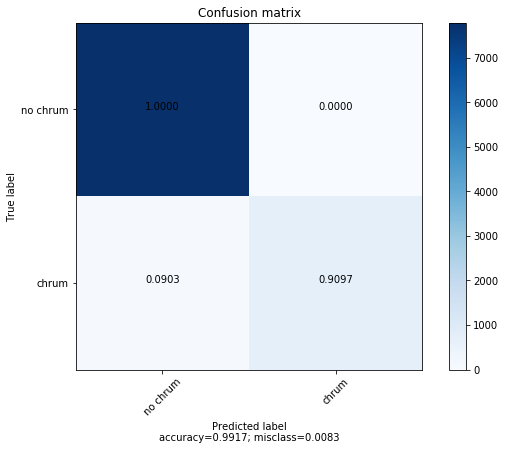

In [38]:
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred_rfc),
                      target_names=['no chrum', 'chrum'])

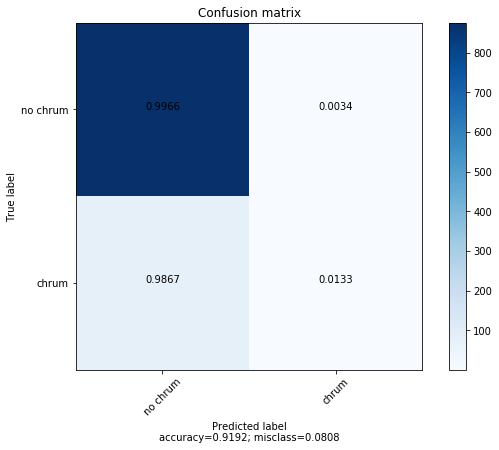

In [39]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred_rfc),
                      target_names=['no chrum', 'chrum'])

Обе модели хорошо показали себя на обучающей выборке, но провалились на валидации, что врядли позволит нам использовать хоть одну из них в прогнозе на будущее.

В зависимости от задачи данным фактом можно пренебречь, если мы строили модель для выявления факторов, повлиявших на уход клиентов. В такой ситуации можно не разделять нашу выборку и воспользоваться моделью случайного леса, которая показала неплохие результаты на обученни и, при дополнительной настройке параметров позволит нам получить достаточно хорошо интерпретируемую модель.

Так же, для решения задачи оттока, возможно имеет смысл, по возможности, уточнить момент, когда клиенты перестали пользоваться продуктом, попытаться найти закономерность в изменении их активности в предверии этого, разнообразить показатели наличием подключенных услуг, роуминга, показателями используемого интернет трафика и др.